# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Salma"
ln1 = "EL BEZ"
fn2 = "Mohamed Rostom"
ln2 = "GHARBI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_el bez_salma_and_gharbi_mohamed rostom.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_bfgs
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
import seaborn

In [4]:
# the usual functions:

def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


### Table of content : 

[1. Part 1](#1)<br>
[2. Part 2](#2)<br>
[3. Part 3](#3)<br>

-------------------------------------------------------------------------------------------------

<a id='1'></a>
## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

- compute a precise minimum with your favorite solver
- compare the performance of cyclic and greedy CD

- could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

In [5]:
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)
n_iter = 10000
A, b = simu(coefs, n_samples=1000, for_logreg=False)

In [6]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const=np.linalg.norm(A,axis=0)**2
    # Lips_const is an array of n features. 
    # END TODO
    
    for t in range(n_iter):
        
        j = t % n_features
        old_w_j =w[j] 
        w[j] += A[:, j].dot(residuals) / lips_const[j]
        residuals += A[:, j]*(old_w_j - w[j])
        
        if t % n_features == 0:
            all_objs.append((residuals ** 2).sum() / 2.)
    
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    lips_const=np.linalg.norm(A,axis=0)**2
    
    for t in range(n_iter):
        
        j = np.argmax(np.abs(gradient))  
        old_w_j =w[j] 
        w[j] -= gradient[j] / lips_const[j]        
        gradient += gram[:, j] * (w[j]-old_w_j)
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

### Compute a precise minimum with your favorite solver

For this, we will use bfgs algorithm to compute the minimum. 

References : https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html

In [7]:
from numpy import linalg as LA

def loss(w,A,b):
    return 0.5*LA.norm(A.dot(w) - b, ord=2)**2

def grad(w,A,b):
    return A.T.dot(A.dot(w) - b)

Those functions will be needed to compute the minimum using the bfgs minimizer. 

In [8]:
x_init = np.zeros(A.shape[1])
x_min = fmin_bfgs(loss, x_init, grad, args=(A, b))
f_min=loss(x_min,A,b)

Optimization terminated successfully.
         Current function value: 466.384977
         Iterations: 119
         Function evaluations: 170
         Gradient evaluations: 170


### Compare the performance of cyclic and greedy CD

In [9]:
_, all_objs_cyclic = cyclic_cd(A, b, n_iter)
_, all_objs_greedy = greedy_cd(A, b, n_iter)

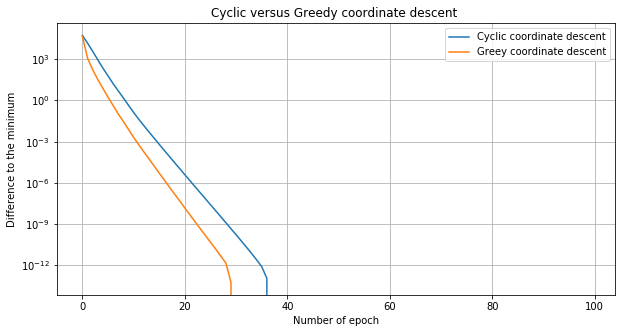

In [10]:
n_epoch=len(all_objs_cyclic)
x_ax=[i for i in range(n_epoch)]
plt.figure(figsize=(10,5))
plt.semilogy(x_ax,all_objs_cyclic-f_min, label='Cyclic coordinate descent')
plt.semilogy(x_ax,all_objs_greedy-f_min, label='Greey coordinate descent')
plt.xlabel('Number of epoch')
plt.legend(loc = 'best')
plt.ylabel('Difference to the minimum')
plt.title("Cyclic versus Greedy coordinate descent ")
plt.grid(True)

#### Comments : 

We clearly see that the greedy coordinate descent is faster than the cyclic coordinate descent.

It is explained by the fact that the greedy algorithm always chooses the direction with the highest gradient. For the greedy algorithm, we choose "j" such as $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$ and that's what makes the greedy algorithm faster. 

### Could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.

#### From mathematic point of view :

In order to use the greedy CD for unregularized logistic regression. Our function $f=\frac 12 \Vert Aw - b \Vert ^2 $ needs to be strictly convex, and thus it's hessian matrix  $\nabla^2f=A^T.A$ is definite positive. Which might not be the case here, with 100,000 features. 

#### From a computational point of view :

When we have the number of features equal to 100,000 not only the computational effort that needs to be made is huge, but also, this requires a large memory, because we will compute $A^TA$ that has 100,000 rows, and also 100,000 columns. 


Computing a matrix $A^TA \in   \mathbb{R}^{100000 x 100000}$ will be very costly. 


-------------------------------------------------------------------------------------------------

<a id='2'></a>
## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

**Answer**

Let  $ g(x) = \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$

1) We have : 

$$\hat w \in \mathrm{arg \, min} g(x) \iff \mathbf{0}_p  \in \partial g(\hat w)$$

2) We calculate the subdifferential of g: 

$$ \partial g(\hat w) =  \sum_{i=1}^{n} \frac{-y_i x_i^\top e^{- y_i w^\top x_i}}{ 1 + e^{- y_i w^\top x_i} } + \partial \Vert \cdot \Vert_1 (\hat w)  $$

3) Applied to the null vector : 
 
$$ \partial g(\mathbf{0}_p) =  \sum_{i=1}^{n} \frac{-y_i x_i^\top }{ 2} + \partial \Vert \cdot \Vert_1 (\mathbf{0}_p)  $$

4) Check that the given necessary condition guaranties that $\mathbf{0}_p \in \partial g(\mathbf{0}_p) $ : 
 
 We have $ \sum_{i=1}^{n} \frac{-y_i x_i^\top }{ 2} = - \frac 12  X^\top y  $
 
So since $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)= [-1, 1]$ , we must have :

$$ 0 \in  [- \frac 12 (X^\top y)_i - \lambda, - \frac 12 (X^\top y)_i + \lambda ],  \forall i \in [1,p] $$  

If $  \lambda \geq  \vert  \frac 12 (X^\top y)_i \vert \forall i \iff \lambda \geq \max_{i} ( \frac 12 \vert (X^\top y)_i\vert) \iff \lambda \geq \lambda_{max}$ then the above condition holds.


2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

**Answer**

We denote $L_i$ the coordinate-wise Lipschitz constant of the logistic regression term:

$$ f(w) =  \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} ) $$

Computing the second derivative according to $ w_i$ gives :

$$ \frac{\partial ^2 f}{(\partial w_i)^2} = \sum_{i=1}^{n} \frac{y_i^2 X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2} $$

The funtion $ \frac{e^x}{(1+e^x)^2} $ reaches its maximum at 0 with value $\frac 14$, therefore

$$ \frac{\partial ^2 f}{(\partial w_i)^2} = \sum_{i=1}^{n} \frac{y_i^2 X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2} \leq  \frac 14 \sum_{i=1}^{n} y_i^2 X_{ij}^2 \leq \frac 14 \sum_{i=1}^{n} X_{ij}^2 = \frac {\Vert X_j \Vert^2 }{4} $$

Which proves the desired result.

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$\sum_i  \frac{X_{i, j}^2 e^{(Xw)_i}}{(1 + e^{(Xw)_i})^2} $$
    
(why is it better?)

Implement it in the code with a `better_lc` parameter, and compare.

**Answer**

This new $L_i$ is better because bigger progress in the gradient step is made when L is smaller.

Let's go back to  $ \frac{\partial ^2 f}{(\partial w_i)^2} = \sum_{i=1}^{n} \frac{y_i^2 X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2} $ .
We also have that $ g(x) = \frac{e^x}{(1+e^x)^2} $ is a positive symetric function  which implies that: 

$$  |x|= |y| \implies g(x) = g(y)$$

And since $\forall i $ we have : $  |y_i w^\top x_i| = |(Xw)_i|$ . We have $ \frac{\partial ^2 f}{(\partial w_i)^2} \leq  \sum_{i=1}^{n} \frac{X_{ij}^2 e^{ y_i w^\top x_i}}{( 1 + e^{ y_i w^\top x_i} )^2}= \sum_i \frac{X_{i, j}^2 e^{(Xw)_i}}{(1 + e^{(Xw)_i})^2} =L_i $. This proves the desired result.

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

In [11]:
##Define initial parameters
n_features = 100
np.random.seed(1970)
coefs = np.random.randn(n_features)

X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.
n_iter=100

In [12]:
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter, better_lc=False):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    all_objs= []
    # TODO
    if better_lc== False: 
        lips_const = [(norm(X[:,j])**2)/4 for j in range(n_features)]
    # END TODO
    
    for t in range(n_iter):
        for j in range(n_features):
            old_w_j = w[j]
            # TODO
            grad_j = - np.sum( y * X[:,j] * sigmoid(-y* Xw))

            if better_lc == False:
                w[j] = np.sign(old_w_j - (1/lips_const[j]) * grad_j) * soft_thresh( old_w_j - (1/lips_const[j]) * grad_j , lamb/lips_const[j])
            else: 
                L_j = np.sum( X[:,j]**2 * (np.exp(Xw) / (1 + np.exp(Xw))**2) )
                w[j] = np.sign(old_w_j - (1/L_j) * grad_j) * soft_thresh(old_w_j -(1/L_j) * grad_j,lamb/L_j)   

            if old_w_j != w[j]:
                Xw += X[:,j] * w[j] - X[:,j] * old_w_j

        #END TODO
        all_objs.append( np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1) )
    
    return w, all_objs

In [13]:
import time 

debut1 = time.time()
w_normal,all_objs_normal = cd_logreg(X, y, lamb, n_iter, better_lc=False)
fin1 = time.time()

debut2 = time.time()
w_normal,all_objs_better = cd_logreg(X, y, lamb, n_iter, better_lc=True)
fin2 = time.time()

** Plots for comparison : better_lc True/False**

In [14]:
print('For the case, better_lc = False :', fin1 - debut1, 's.')
print('For the case, better_lc = True :', fin2 - debut2, 's.')

For the case, better_lc = False : 0.5998077392578125 s.
For the case, better_lc = True : 1.0956313610076904 s.


In term of time, we clearly see that when better_lc is equal to False, it takes less time to compute the objective function, than when it is equal to True. 

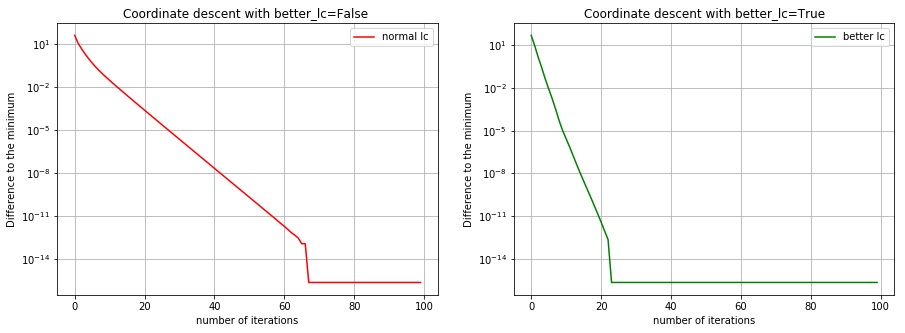

In [15]:
x_ax = [i for i in range(n_iter)]
eps = np.finfo('float').eps

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.semilogy(x_ax, np.maximum(all_objs_normal[:n_iter] - all_objs_better[-1], eps) ,'r-', 
             label ='normal lc')
plt.xlabel('number of iterations')
plt.legend(loc = 'best')
plt.ylabel('Difference to the minimum')
plt.title("Coordinate descent with better_lc=False ")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.semilogy(x_ax, np.maximum(all_objs_better[:n_iter]- all_objs_better[-1], eps),'g-', label ='better lc')
plt.xlabel('number of iterations')
plt.legend(loc = 'best')
plt.ylabel('Difference to the minimum')
plt.title("Coordinate descent with better_lc=True")
plt.grid(True)

plt.show()

In terms of number of iterations, we clearly see that when better_lc is equal to True, it convergs to the minimum with less iterations.


**Comments**

As expected the CD with the w-dependant Lipschitz constant is faster in terms of iterations. In fact, as explained above, bigger progress is made at each step of coordinate-wise gradient descent since  $step=\frac{1}{L}$ is bigger for the w-dependant Lipschitz constant. The wiggly tails are dues to numpy precision issues.

-------------------------------------------------------------------------------------------------

<a id='3'></a>
# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [16]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y[::10])

(72, 7128)
[ 1  1 -1 -1  1  1  1 -1]


In [17]:
lambda_max_lasso = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max_lasso / 10.

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [18]:
def ISTA(X,y,lamb, n_iter):
    
    n_samples,n_features = X.shape
    w = np.zeros(n_features)
    all_objs = []
    L = norm(X, 2) ** 2 / (4 * n_samples)
    
    for k in range(n_iter):
        grad_w = np.sum( (-y * X.T) *  (1 / (1 + np.exp(y * X.dot(w)))), axis=1 )
        w = np.sign(w - (1./L) * grad_w) * soft_thresh(w - (1./L) * grad_w, lamb * (1./L))
        all_objs.append(np.log(1. + np.exp(-y * X.dot(w))).sum() + lamb * norm(w, ord=1))
    
    return w, all_objs

In [19]:
n_iter = 200

debut1 = time.time()
_,all_objs_ista = ISTA(X,y,lamb,n_iter)
fin1 = time.time()

debut2 = time.time()
_,all_objs_ccd = cd_logreg(X, y, lamb, n_iter, better_lc=True)
fin2 = time.time()

In [20]:
print('For ISTA :', fin1 - debut1, 's.')
print('For prox cd solver :', fin2 - debut2, 's.')

For ISTA : 0.771216630935669 s.
For prox cd solver : 52.162750244140625 s.


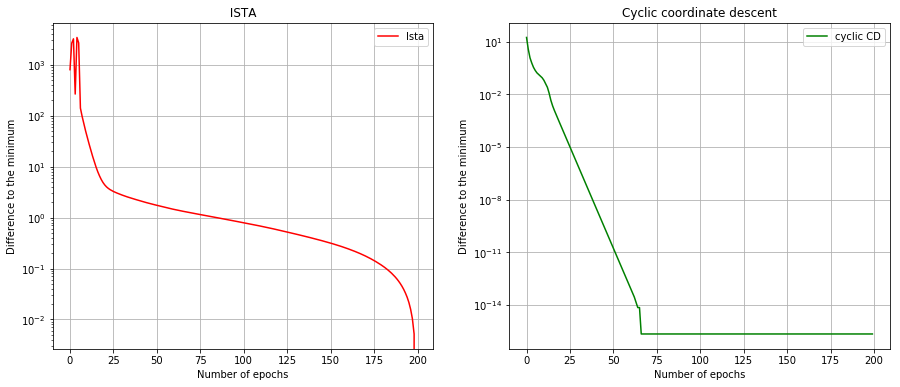

In [21]:
x_ax = [i for i in range(n_iter)]

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.semilogy(x_ax, all_objs_ista[:n_iter] - all_objs_ista[-1] ,'r-', 
             label ='Ista')
plt.xlabel('Number of epochs')
plt.legend(loc = 'best')
plt.ylabel('Difference to the minimum')
plt.title(" ISTA ")
plt.grid(True)


#n_epoch=len(all_objs_ccd)
plt.subplot(1, 2, 2)
plt.semilogy(x_ax, np.maximum(all_objs_ccd[:n_iter]- all_objs_ccd[-1], eps),'g-', label='cyclic CD')
plt.xlabel('Number of epochs')
plt.legend(loc = 'best')
plt.ylabel('Difference to the minimum')
plt.title("Cyclic coordinate descent")
plt.grid(True)

plt.show()

Comments : 

- In term of time, ISTA takes very much less time to compute than the cyclic coordinate descent.

- In term of number of epochs, the cyclic coordinate descent gets faster to the minimum than ISTA. 

- On the other hand, we need to mention that for this case, we are young a matrix X with 72 features, and that it why ISTA was faster. We need to remember what we said above in part 1 about increasing the features and it's effect on the coordinate descent performance. 